# Part 2 Fashion Product Classification by CNN on Product Image and MLP on Product Name

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load train and test labels

In [3]:
test = pd.read_csv("test.csv",
           header=0, 
           sep="	")
test

,imageid,label,productname
0,21131,Topwear,s.Oliver Women Solid White Top
1,27837,Others,Bulchee Men Plain Jeans Black Belt
2,47649,Shoes,Carlton London Men Brown Shoes
3,49717,Others,Park Avenue Black & Red Checked Tie
4,4868,Topwear,Levis Kids Boy's Darby Orange Polo Tshirt
...,...,...,...
3995,7928,Topwear,Proline Men Olive Green Polo T-shirt
3996,21254,Bags,Skybags Unisex Maroon Duffle Bag
3997,58463,Others,Fossil Men Black Belt
3998,38025,Watches,Q&Q Women Steel Dial Watch


In [4]:
train = pd.read_csv("train.csv",
           header=0, 
           sep="	")
train

,imageid,label,productname
0,2653,Bags,Murcia Women Leather Office Grey Bag
1,55997,Others,Colorbar Velvet Matte Temptation Lipstick 24MA
2,2640,Shoes,Carlton London Men Brown Formal Shoes
3,40565,Topwear,W Women Maroon Kurta
4,38932,Bottomwear,Gini and Jony Girls Pink Leggings
...,...,...,...
40436,5815,Topwear,Puma Men's Sports Grey T-shirt
40437,55200,Others,Lakme Lip Love Charmer Lip Conditioner
40438,11294,Bottomwear,Wrangler Men Blue Floyd Jeans
40439,30620,Topwear,Nike Men Printed Green T-shirt


### Drop rows with any of null imageid, label, or description

In [5]:
train, test = train.dropna(), test.dropna()

### Load images
Since there are a few grayscale images in the dataset, I decided to omit them.  I imagine any modern and quality product listing would have a colour image. 

In [6]:
def load_images(labels):
    images = []
    grayscale_img_ids = []
    
    for fname in labels['imageid']:
        img_arr = np.asarray(Image.open(os.path.join("images", str(fname)+".jpg")).resize((60, 80)))
        
        # don't add the image if its not RGB
        if len(img_arr.shape)<3:
            grayscale_img_ids.append(fname)
        else:
            images.append(img_arr/255.0)
            
    # the remove grayscale labels
    labels = labels[~labels['imageid'].isin(grayscale_img_ids)].copy()
    return labels, np.asarray(images)

In [7]:
train_labels, train_images = load_images(train)

In [8]:
test_labels, test_images = load_images(test)

In [11]:
xi_train = train_images
xi_test = test_images

In [12]:
labels = train_labels['label'].unique().tolist()
labels

['Bags',
 'Others',
 'Shoes',
 'Topwear',
 'Bottomwear',
 'Innerwear',
 'Eyewear',
 'Jewellery',
 'Sandal',
 'Watches',
 'Fragrance',
 'Wallets',
 'Makeup']

### Prepare labels

In [13]:
# we convert the string labels to integers, and then apply onehot encoding. 
y_train = to_categorical(train_labels["label"].apply(lambda x: labels.index(x)).to_numpy())
y_test = to_categorical(test_labels["label"].apply(lambda x: labels.index(x)).to_numpy())


### Prepare description features

We transform the product name/description into an array of integers, which represents the number of occurances of the max_vocab most frequent words in the training dataset. 

In [14]:
max_vocab = 500
count_vect = CountVectorizer(max_features=max_vocab)
xw_train = count_vect.fit_transform(train_labels['productname'])
xw_test = count_vect.transform(test_labels['productname'])

In [15]:
xw_train = xw_train.toarray()
xw_test = xw_test.toarray()

### Confirm shapes match for images, word frequencies, and labels

In [16]:
[x.shape for x in [xi_train, xw_train, y_train]]

[(40047, 80, 60, 3), (40047, 500), (40047, 13)]

### Text NN Model Design

In [17]:
text_model_input = Input(shape=(max_vocab), name='text_input')

x = Dense(200)(text_model_input)
x = Dense(100)(x)
x = Dense(20)(x)

text_model_output = Dense(13, activation='softmax')(x)

mlp = Model(text_model_input, text_model_output, name="textmlp")
mlp.summary()


Model: "textmlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               100200    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 13)                273       
Total params: 122,593
Trainable params: 122,593
Non-trainable params: 0
_________________________________________________________________


### Image Model Design

In [18]:
image_model_input = Input(shape=(80, 60, 3), name='image_input')

x = Conv2D(16, 3, activation='relu')(image_model_input)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)


x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_model_output = Dense(13, activation='softmax')(x)

cnn = Model(image_model_input, image_model_output, name="simplecnn")
cnn.summary()


Model: "simplecnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 58, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 29, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 13, 32)        0 

### Combined Model
We concatenate the outputs of the image and text models into one combined model. 

In [19]:
x = concatenate([image_model_output, text_model_output])
combined_output = Dense(13, activation='softmax')(x)

combined_model = Model(
    inputs=[image_model_input, text_model_input],
    outputs=[combined_output]
)
combined_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 80, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 58, 16)   448         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 39, 29, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 39, 29, 16)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

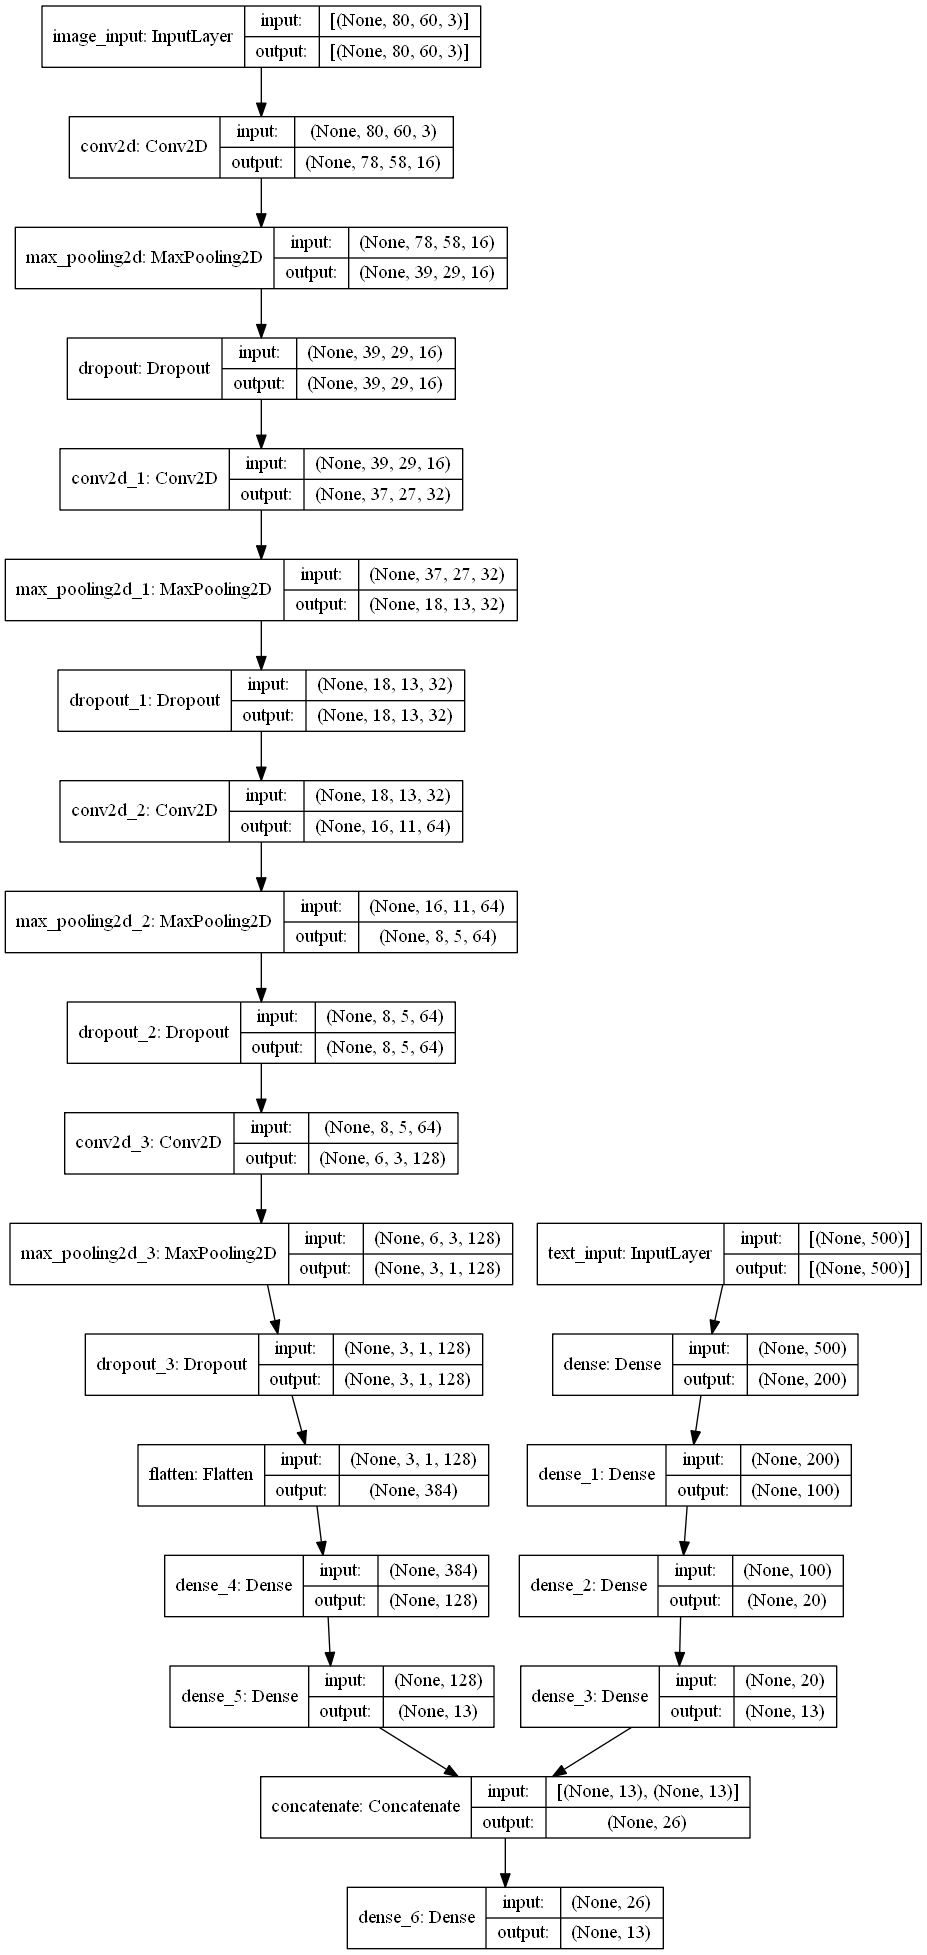

In [20]:
plot_model(combined_model, "image_and_text_classifier.png", show_shapes=True)

### Model Training

In [21]:
combined_model.compile(
    optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

In [22]:
history = combined_model.fit(
    {"image_input": xi_train, "text_input": xw_train},
    y_train,
    validation_data=({"image_input": xi_test, "text_input": xw_test}, y_test),
    epochs=50
)

Epoch 1/50
1252/1252 [==============================] - 12s 7ms/step - loss: 1.7894 - accuracy: 0.5175 - val_loss: 1.0574 - val_accuracy: 0.7563
Epoch 2/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.9863 - accuracy: 0.7588 - val_loss: 0.6769 - val_accuracy: 0.8268
Epoch 3/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.6289 - accuracy: 0.8325 - val_loss: 0.5534 - val_accuracy: 0.8246
Epoch 4/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5325 - accuracy: 0.8317 - val_loss: 0.4495 - val_accuracy: 0.8564
Epoch 5/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.4328 - accuracy: 0.8544 - val_loss: 0.3927 - val_accuracy: 0.8567
Epoch 6/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.3795 - accuracy: 0.8575 - val_loss: 0.3714 - val_accuracy: 0.8567
Epoch 7/50
1252/1252 [==============================] - 8s 6ms/step - loss: 0.3570 - accuracy: 0.8601 - val_loss: 0.3510 - val_accuracy

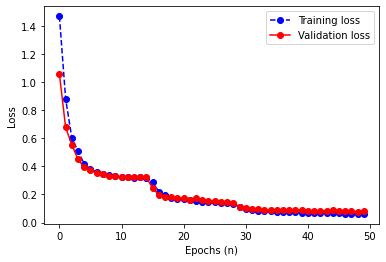

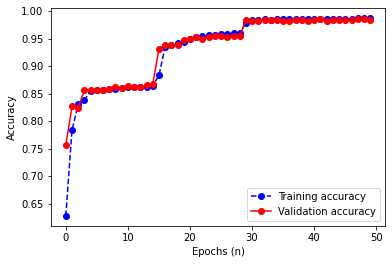

In [23]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

### Results

In [ ]:
train_loss, train_acc = combined_model.evaluate(x={"image_input": xi_train, "text_input": xw_train},
                                              y=y_train)
print("The model performed with a training accuracy of {:.2f}%".format(train_acc*100))

In [24]:
test_loss, test_acc = combined_model.evaluate(x={"image_input": xi_test, "text_input": xw_test},
                                              y=y_test)
print("The model performed with a testing accuracy of {:.2f}%".format(test_acc*100))

124/124 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9843
The model performed with and accuracy of 98.43%


In [25]:
combined_model.save("combined_model_98acc")

INFO:tensorflow:Assets written to: combined_model_98acc\assets


In [28]:
import pickle
with open("combined_model_98acc_history", 'wb') as hist_out:
    pickle.dump(history.history, hist_out)